In [3]:
!pip install konlpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
import pandas as pd
import numpy as np

from collections import Counter
from konlpy.tag import Okt
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from sklearn.feature_extraction.text import TfidfVectorizer
from tensorflow.keras.models import load_model

from tensorflow.keras.layers import Embedding, Dense, LSTM, Bidirectional
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [5]:
from google.colab import files
file_uploaded = files.upload()

Saving unsmile_train_new.csv to unsmile_train_new.csv
Saving unsmile_valid_new.csv to unsmile_valid_new.csv


In [6]:
df_train = pd.read_csv("unsmile_train_new.csv")
df_valid = pd.read_csv("unsmile_valid_new.csv")

In [7]:
df_train.head()

,문장,target
0,일안하는 시간은 쉬고싶어서 그런게 아닐까,0
1,아동성범죄와 페도버는 기록바 끊어져 영원히 고통 받는다. 무슬림 50퍼 근친이다. ...,1
2,루나 솔로앨범 나왔을 때부터 머모 기운 있었음 ㅇㅇ Keep o doin 진짜 띵...,0
3,홍팍에도 어버이연합인가 보내요 뭐 이런뎃글 있는데 이거 어버이연합측에 신고하면 그쪽...,0
4,아놔 왜 여기 댓들은 다 여자들이 김치녀라고 먼저 불렸다! 여자들은 더 심하게 그런...,1


In [ ]:
okt = Okt()

In [ ]:
print('OKT 형태소 분석 :',okt.morphs("열심히 코딩한 당신, 연휴에는 여행을 가봐요"))
print('OKT 품사 태깅 :',okt.pos("열심히 코딩한 당신, 연휴에는 여행을 가봐요"))
print('OKT 명사 추출 :',okt.nouns("열심히 코딩한 당신, 연휴에는 여행을 가봐요"))

OKT 형태소 분석 : ['열심히', '코딩', '한', '당신', ',', '연휴', '에는', '여행', '을', '가봐요']
OKT 품사 태깅 : [('열심히', 'Adverb'), ('코딩', 'Noun'), ('한', 'Josa'), ('당신', 'Noun'), (',', 'Punctuation'), ('연휴', 'Noun'), ('에는', 'Josa'), ('여행', 'Noun'), ('을', 'Josa'), ('가봐요', 'Verb')]
OKT 명사 추출 : ['코딩', '당신', '연휴', '여행']


In [8]:
def make_corpus(sentence):
    okt = Okt()
    raw_pos_tagged = okt.pos(sentence, norm=True, stem=True)
    word_cleaned = []

    for word in raw_pos_tagged:
        if word[1] in ['Noun', 'Adjective', 'Verb']:
            word_cleaned.append(word[0])
    return ' '.join(word_cleaned)

In [9]:
df_train['tokenized'] = df_train['문장'].map(make_corpus)
df_valid['tokenized'] = df_valid['문장'].map(make_corpus)

In [10]:
tfidf_vect = TfidfVectorizer(max_features=100)
tfidf_vect.fit(df_train.tokenized)
df_train_tfidf = tfidf_vect.transform(df_train.tokenized)
df_valid_tfidf = tfidf_vect.transform(df_valid.tokenized)

In [11]:
df_train_tfidf = df_train_tfidf.toarray()
df_valid_tfidf = df_valid_tfidf.toarray()

In [12]:
X_train = df_train_tfidf
X_test = df_valid_tfidf
y_train = df_train['target']
y_test = df_valid['target']

In [13]:
print("X_train shape: ", X_train.shape)
print("X_test shape: ", X_test.shape)
print("y_train shape: ", y_train.shape)
print("y_test shape: ", y_test.shape)

X_train shape:  (22532, 100)
X_test shape:  (5604, 100)
y_train shape:  (22532,)
y_test shape:  (5604,)


In [14]:
embedding_dim = 100
hidden_units = 128

model = Sequential()
model.add(Embedding(6, embedding_dim))
# model.add(Bidirectional(LSTM(hidden_units))) # Bidirectional LSTM을 사용
model.add(LSTM(hidden_units))
model.add(Dense(1, activation='sigmoid'))

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('best_model_old.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(X_train, y_train, epochs=5, callbacks=[es, mc], batch_size=256, validation_split=0.2)

Epoch 1/5
71/71 [==============================] - ETA: 0s - loss: 0.6630 - acc: 0.6250
Epoch 1: val_acc improved from -inf to 0.00000, saving model to best_model_old.h5
71/71 [==============================] - 49s 627ms/step - loss: 0.6630 - acc: 0.6250 - val_loss: 0.8437 - val_acc: 0.0000e+00
Epoch 2/5
71/71 [==============================] - ETA: 0s - loss: 0.6602 - acc: 0.6274
Epoch 2: val_acc improved from 0.00000 to 0.08298, saving model to best_model_old.h5
71/71 [==============================] - 43s 613ms/step - loss: 0.6602 - acc: 0.6274 - val_loss: 1.2876 - val_acc: 0.0830
Epoch 3/5
71/71 [==============================] - ETA: 0s - loss: 0.6582 - acc: 0.6333
Epoch 3: val_acc improved from 0.08298 to 0.11715, saving model to best_model_old.h5
71/71 [==============================] - 43s 608ms/step - loss: 0.6582 - acc: 0.6333 - val_loss: 1.0165 - val_acc: 0.1172
Epoch 4/5
71/71 [==============================] - ETA: 0s - loss: 0.6526 - acc: 0.6343
Epoch 4: val_acc did not i

In [16]:
loaded_model = load_model('best_model_old.h5')

print("\n 테스트 정확도: %.4f" % (loaded_model.evaluate(X_test, y_test)[1]))

176/176 [==============================] - 6s 33ms/step - loss: 0.7270 - acc: 0.5341

 테스트 정확도: 0.5341


In [17]:
print("\n 테스트 정확도: %.4f" % (model.evaluate(X_test, y_test)[1]))

176/176 [==============================] - 11s 59ms/step - loss: 0.7077 - acc: 0.5268

 테스트 정확도: 0.5268


In [19]:
preds = model.predict(X_test)

In [20]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

# clf = LogisticRegression(solver="liblinear", random_state=0).fit(X_test, y_test)

# roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1]) 
AUC = roc_auc_score(y_test, preds)     

# y_pred = model.predict(test_labels)
precision = precision_score(y_test, np.round(abs(preds))) 
f1 = f1_score(y_test, np.round(abs(preds))) 

print("AUC : ", AUC)
print("Precision Score : ", precision)
print("f1 Score : ", f1)

AUC :  0.5208722764049947
Precision Score :  0.5143293847917463
f1 Score :  0.6699850671976108


In [21]:
embedding_dim = 100
hidden_units = 128

model = Sequential()
model.add(Embedding(6, embedding_dim))
model.add(Bidirectional(LSTM(hidden_units))) # Bidirectional LSTM을 사용
# model.add(LSTM(hidden_units))
model.add(Dense(1, activation='sigmoid'))

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('best_model_new_biLSTM.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(X_train, y_train, epochs=5, callbacks=[es, mc], batch_size=256, validation_split=0.2)

Epoch 1/5
71/71 [==============================] - ETA: 0s - loss: 0.6627 - acc: 0.6250
Epoch 1: val_acc improved from -inf to 0.00000, saving model to best_model_new_biLSTM.h5
71/71 [==============================] - 91s 1s/step - loss: 0.6627 - acc: 0.6250 - val_loss: 0.8920 - val_acc: 0.0000e+00
Epoch 2/5
71/71 [==============================] - ETA: 0s - loss: 0.6592 - acc: 0.6296
Epoch 2: val_acc improved from 0.00000 to 0.08165, saving model to best_model_new_biLSTM.h5
71/71 [==============================] - 84s 1s/step - loss: 0.6592 - acc: 0.6296 - val_loss: 0.9520 - val_acc: 0.0817
Epoch 3/5
71/71 [==============================] - ETA: 0s - loss: 0.6560 - acc: 0.6355
Epoch 3: val_acc improved from 0.08165 to 0.15065, saving model to best_model_new_biLSTM.h5
71/71 [==============================] - 84s 1s/step - loss: 0.6560 - acc: 0.6355 - val_loss: 0.9084 - val_acc: 0.1507
Epoch 4/5
71/71 [==============================] - ETA: 0s - loss: 0.6500 - acc: 0.6449
Epoch 4: val_a

In [22]:
loaded_model = load_model('best_model_new_biLSTM.h5')

print("\n 테스트 정확도: %.4f" % (loaded_model.evaluate(X_test, y_test)[1]))

176/176 [==============================] - 9s 47ms/step - loss: 0.7086 - acc: 0.5448

 테스트 정확도: 0.5448


In [23]:
preds = model.predict(X_test)

In [24]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

# clf = LogisticRegression(solver="liblinear", random_state=0).fit(X_test, y_test)

# roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1]) 
AUC = roc_auc_score(y_test, preds)     

# y_pred = model.predict(test_labels)
precision = precision_score(y_test, np.round(abs(preds))) 
f1 = f1_score(y_test, np.round(abs(preds))) 

print("AUC : ", AUC)
print("Precision Score : ", precision)
print("f1 Score : ", f1)

AUC :  0.5420989570516829
Precision Score :  0.5214541120381406
f1 Score :  0.6699846860643185


In [ ]:
# 모델 구조 그림
!pip install graphviz
!pip install pydot

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


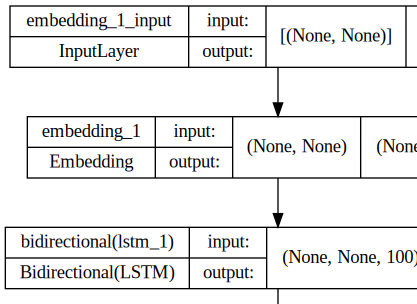

In [ ]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

%matplotlib inline

SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

시각화 프로그램
* https://gaussian37.github.io/dl-keras-%EC%BC%80%EB%9D%BC%EC%8A%A4-%EB%AA%A8%EB%8D%B8-%EC%8B%9C%EA%B0%81%ED%99%94/
* https://github.com/gaussian37/netron